In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import csv
import os
import random
import statistics 

## Generate and Cleanup Datasets

In [6]:
def split_dataset(train_dataset, test_dataset):
    """Split CSV file into training and testing"""
    
    df = pd.read_csv("datasets/master_dataset.csv")
    msk = np.random.rand(len(df)) <= 0.7
    
    train = df[msk]
    test = df[~msk]
    train.to_csv(train_dataset, index=False)
    test.to_csv(test_dataset, index=False)

split_dataset("datasets/master_train.csv", "datasets/master_test.csv")

In [85]:
def combine_microbenchmarks(path, name, phase):
    """Combine individual benchmark files from microbenchmarks"""
    
    discard_files = ["clock.txt", "time.txt", ".DS_Store"]
    configs = {'LITTLE': "0", 'big': "1"}
    config_folders = os.listdir(path)
    config_folders = [folder for folder in config_folders if folder not in discard_files]
    dataframe_collections = []
    for config in config_folders:
        
        # Ensure path is a folder
        if not os.path.isdir(f"{path}/{config}/"):
            continue
            
        # Skip big config (for testing purposes)
        if config == "LITTLE":
            continue

        # List the files, each containing date points for a PMC
        data_files = os.listdir(f"{path}/{config}/")
        data_files = [file for file in data_files if file not in discard_files and file.endswith(".txt")]
        
        # Append column headers to CSV
        column_headers = [file.split('.')[0] for file in data_files]
        column_headers.append("cluster")
        column_headers.append("phase")
        
        # Insert data from individual file as a column
        df = pd.DataFrame(columns=column_headers)
        for file in data_files:
            with open(f"{path}/{config}/{file}", "r") as text_file:
                lines = text_file.read().splitlines()
                df[file.split('.')[0]] = lines
                df['cluster'] = configs[config]
                df['phase'] = phase
        df = df.iloc[100:] # skip first 'x' rows (first few values may not be representative of the phase)
        df = df.iloc[:-100] # skip last 'x' rows (last few values may not be representative of the phase)
        dataframe_collections.append(df)
        
        # Create and return CSV
        df.to_csv(f"{path}/{config}/{name}_{config}.csv", index=False)
        master_dataframes = pd.concat(dataframe_collections)
        master_dataframes.to_csv(f"{path}/{name}.csv", index=False)

    return master_dataframes

In [1]:
def combine_spec2006(path, name, phase):
    """Combine individual benchmark files for SPEC2006"""
    
    # Ensure path is valid
    if not os.path.isdir(path):
        return

    discard_files = ["dtlb_misses.txt", "l1_data_accesses.txt", "clock.txt", "time.txt", ".DS_Store"]
    configs = {'LITTLE': "0", 'big': "1"}
    config_folders = os.listdir(path)
    config_folders = [folder for folder in config_folders if folder not in discard_files]
    dataframe_collections = []
    for config in config_folders:
        
        # Ensure path is a folder
        if not os.path.isdir(f"{path}/{config}/"):
            continue
            
        # Skip big config (for testing purposes)
        """
        if "big" in config:
            continue
        """

        # List the files, each containing date points for a PMC
        data_files = os.listdir(f"{path}/{config}/")
        data_files = [file for file in data_files if file not in discard_files and file.endswith(".txt")]

        # Append column headers to CSV
        column_headers = [file.split('.')[0] for file in data_files]
        column_headers.append("cluster")
        column_headers.append("phase")

        # Insert data from individual file as a column
        df = pd.DataFrame(columns=column_headers)
        for file in data_files:
            with open(f"{path}/{config}/{file}", "r") as text_file:
                lines = text_file.read().splitlines()
                df[file.split('.')[0]] = lines
                df['cluster'] = "0" if "LITTLE" in config else "1"
                df['phase'] = phase
        df = df.iloc[200:] # skip first 'x' rows (first few values may not be representative of the phase)
        df = df.iloc[:-200] # skip last 'x' rows (last few values may not be representative of the phase)
        dataframe_collections.append(df)
        
        # Create and return CSV
        df.to_csv(f"{path}/{config}/{name}_{config}.csv", index=False)
        master_dataframes = pd.concat(dataframe_collections)
        master_dataframes.to_csv(f"{path}/{name}.csv", index=False)

    return master_dataframes

In [86]:
def generate_datasets_microbenchmarks():
    """Generate CSVs from raw PMC files from microbenchmarks"""
    
    path = "../datasets/microbenchmarks"
    phase = {'cpu': "0", 'mem': "1"}
    benchmarks = os.listdir(path)
    dataframe_collections = []
    for benchmark in benchmarks:
        
        if benchmark == "iso" or benchmark == "nate":
            continue
        
        if not os.path.isdir(f"{path}/{benchmark}"):
            continue
                                        
        phase_folders = os.listdir(f"{path}/{benchmark}")
        for folder in phase_folders:
            folder_path = f"{path}/{benchmark}/{folder}"
            if folder in phase:
                df = combine_microbenchmarks(folder_path, folder, phase[folder])
                dataframe_collections.append(df)

        master_dataframes = pd.concat(dataframe_collections)
        master_dataframes.to_csv('datasets/microbenchmarks_dataset.csv', index=False)

generate_datasets_microbenchmarks()

In [4]:
def generate_datasets_spec2006():
    """Generate CSVs from raw PMC files for SPEC2006"""
    
    # '2': phased, '1': memory-intensive, '0': cpu-intensive
    phases = {
        'astar': "2",
        'sjeng': "2",
        'leslie3d': "2",
        'GemsFDTD': "1",
        'mcf':  "1",
        'milc':  "1",
        'calculix':  "0",
        'gromacs': "0",
        'povray': "0",
    }
    path = "../datasets/mosse-spec2006"
    discard_files = [".DS_Store"]
    benchmarks = os.listdir(path)
#     benchmarks = [b for b in benchmarks if b not in discard_files]
    cpu_benchmarks = ["povray", "gromacs", "calculix"]
    mem_benchmarks = ["GemsFDTD", "mcf", "milc"]
    phased_benchmarks = ["sjeng", "astar", "leslie3d"]
#     benchmarks = [val for pair in zip(cpu_benchmarks, mem_benchmarks) for val in pair]
    benchmarks = cpu_benchmarks + mem_benchmarks + phased_benchmarks
    dataframe_collections = []
    for benchmark in benchmarks:
        # Combine SPEC2006 benchmarks into a master CSV
        configuration_folders = os.listdir(f"{path}/{benchmark}")
        folder_path = f"{path}/{benchmark}"
        print(benchmark) # debug
        df = combine_spec2006(folder_path, benchmark, phases[benchmark])
        
        # Append to master dataframe
        dataframe_collections.append(df)
        master_dataframes = pd.concat(dataframe_collections)
        master_dataframes.to_csv('datasets/master_dataset.csv', index=False)

generate_datasets_spec2006()

povray
gromacs
calculix
GemsFDTD
mcf
milc
sjeng
astar
leslie3d


In [ ]:
def combine_datasets(datasets):
    """Combine multiple datasets"""
    
    print(datasets)
    master = pd.concat([pd.read_csv(dataset) for dataset in datasets])      
    master.to_csv("training_master_dataset.csv", index=False)
    
datasets = ["smoothed_spec2006.csv", "smoothed_micro.csv"]
combine_datasets(datasets)

## Filter and Plot Datasets

In [87]:
from scipy.signal import savgol_filter

def filter_data(col):
    """Helper function to perform Savitzky–Golay filter"""
    return savgol_filter(col, 53, 1).astype(int)

def filter_benchmarks(dataset_name):
    """Filter datasets using Savitzky–Golay filter"""
    
    # Read dataset
    df = pd.read_csv(f"datasets/{dataset_name}.csv")
    smooth_cols = df.iloc[:,:-2]
    unsmooth_cols = df.iloc[:,-2:]
    
    # Filter the dataset using Savitzky-Golay smoothing filter
    smoothed_data = smooth_cols.apply(filter_data)
    smoothed_data = pd.concat([smoothed_data, unsmooth_cols], axis=1)
    smoothed_data.to_csv(f"datasets/smoothed_{dataset_name}.csv", index=False)
    
filter_benchmarks("microbenchmarks_dataset")

In [ ]:
def create_datasets(dataset):
    """Generate and filter dataset"""
    
    if dataset == "spec":
        generate_datasets_spec2006()
        filter_benchmarks("spec2006")
    else:
        generate_datasets_microbenchmarks()
        filter_benchmarks("micro")

create_datasets("spec")

## Plot Datasets

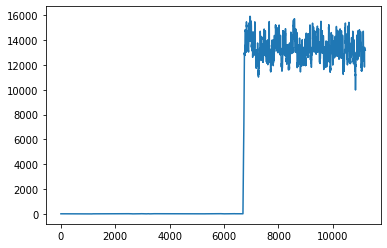

In [89]:
def plot_datasets(dataset):
    """Plot datasets"""
    
    df = pd.read_csv(f"datasets/{dataset}")
    plt.plot(df['llc_misses'])
    
plot_datasets("smoothed_microbenchmarks_dataset.csv")

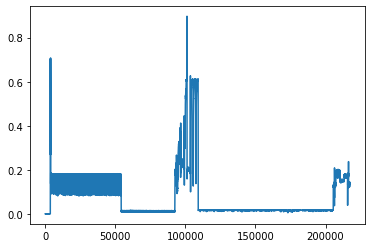

In [60]:
def calculate_groundtruth(dataset):
    """Calculate ground-truth for applications"""
    
    df = pd.read_csv(dataset)
    
    master = pd.DataFrame()
    master['bus/instr'] = df['bus_accesses'] / df['instr']
    plt.plot(master['bus/instr'])
    
calculate_groundtruth(".csv")
    

In [11]:
def calculate_difference(dataset):
    """Calculate difference between points"""
    
    # Read dataset
    dataset = pd.read_csv(dataset)
    discard = ["phase", "cluster"]
    pmcs = [pmc for pmc in dataset if pmc not in discard]

    # Calculate percentage difference
    master = pd.DataFrame()
    alpha = 0.9
    window_size = 100
    
    for pmc in dataset:
        if pmc == "cluster" or pmc == "phase":
            continue
        col = dataset[pmc]
        col_size = len(col)
        pct_change = []
        
        for i in range(window_size, col_size):
#             prev_avg = ((sum(col[i - window_size:i]) / window_size) * (1-alpha))
#             curr = (col[i] * alpha)
            prev_avg = statistics.median(col[i - window_size:i])
            curr = (col[i])
            
            # calculate percentage change
            change = (curr - prev_avg) / (prev_avg)
            pct_change.append(change)
        master[pmc] = pct_change
    
    for d in discard:
        master[d] = dataset[d]
    
    # Determine phase changes
    col = dataset['phase']
    col_size = len(dataset['phase'])
    phase_changes = []
    for i in range(window_size, col_size):
        col_window = col[i - window_size:i]
        phase_change = len(set(col_window)) > 1
        if phase_change == True:
            phase_changes.append("1")
        else:
            phase_changes.append("0")
            
    master['change'] = phase_changes
    
    # Write dataframe to CSV 
    master.to_csv('datasets/spec2006_pctchange.csv', index=False)
    
calculate_difference("datasets/smoothed_spec2006.csv")

## Model Training

In [34]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import pickle

def train_model():
    # Read dataset
    dataset = pd.read_csv("datasets/master_train.csv")
    labels = dataset.iloc[:,-2]
    features = dataset[['cycles', 'instr', 'llc_accesses', 'llc_misses', 'bus_accesses']]

    # Split dataset into training and testing
    X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                        test_size=0.15, shuffle=True)

    # Scale data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Train SVM model
    """
    model = SVC(kernel="rbf")
    model.fit(X_train, y_train.values.ravel())
    """

    """
    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(X_train, y_train.values.ravel())
    """

    model = DecisionTreeClassifier(max_depth=5)
    model.fit(X_train, y_train)

    # Test model model
    test_score = model.score(X_test, y_test.values.ravel())
    print(test_score)

    # Output model to pickle file
    pickle.dump(model, open("phases-model.pkl", "wb"))

    # Output scalr to pickle file
    pickle.dump(scaler, open("phases-scaler.pkl", "wb"))
    
train_model()

0.9224819062234296


## Machine Learning Pipeline

## Model Testing

In [35]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pickle import load

# Read dataset
dataset = pd.read_csv("datasets/master_test.csv")
labels = dataset.iloc[:,-2]
# features = dataset.iloc[:,:-1]
features = dataset[['cycles', 'instr', 'llc_accesses', 'llc_misses', 'bus_accesses']]

# Load models 
model = load(open("phases-model.pkl", "rb"))
scaler = load(open("phases-scaler.pkl", "rb"))

# Scale data
features = scaler.transform(features)

# Test SVM model
test_score = model.score(features, labels)
print(test_score)

0.9225772663461329


## Generate Tree Code

In [4]:
import pandas as pd
import math
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.tree import export_graphviz
from io import StringIO
import pydotplus
from IPython.display import Image  
from pickle import load

import numpy as np

def visualize_dtc(feature_cols, col_names):
    """Visualization of Decision Tree Classifier"""    
    dot_data = StringIO()
    export_graphviz(clf, 
                    out_file=dot_data, 
                    filled=True, 
                    rounded=True,
                    special_characters=True,
                    feature_names=feature_cols,
                    class_names=col_names[-1])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png("dec_tree.png")
    Image(graph.create_png())

# Columns
col_names = ['cycles', 'instr', 'llc_accesses', 'llc_misses', 'bus_accesses', 'phase']
feature_cols = col_names[:-1]

# Visualize DTC
# visualize_dtc(feature_cols, col_names)
    
# Load models 
clf = load(open("phases-model.pkl", "rb"))

# Assign variables
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
value = clf.tree_.value

# Parse through the Decision Tree
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

# Generate GOTO statements
for i in range(n_nodes):
    if is_leaves[i]:
        the_value = value[i]
        the_label = clf.classes_[np.argmax(the_value)]
        print("NODE_"+str(i)+":")
        print("%s%s%s%s" % ("return ", "\"",the_label, "\";"))

    else:
        feat_name = str(feature_cols[feature[i]])
        print("NODE_"+str(i)+":")
        print("%s%s%s%s%s" % ("if (", feat_name, " <= ", math.floor(threshold[i]), ") {"))
        print("\tgoto NODE_"+str(children_left[i])+";")
        print("} else {")
        print("\t goto NODE_"+str(children_right[i])+";")
        print("}")

NODE_0:
if (cycles <= 0) {
	goto NODE_1;
} else {
	 goto NODE_22;
}
NODE_1:
if (bus_accesses <= 1) {
	goto NODE_2;
} else {
	 goto NODE_15;
}
NODE_2:
if (instr <= 1) {
	goto NODE_3;
} else {
	 goto NODE_10;
}
NODE_3:
if (llc_accesses <= 1) {
	goto NODE_4;
} else {
	 goto NODE_7;
}
NODE_4:
if (cycles <= -1) {
	goto NODE_5;
} else {
	 goto NODE_6;
}
NODE_5:
return "0";
NODE_6:
return "0";
NODE_7:
if (cycles <= 0) {
	goto NODE_8;
} else {
	 goto NODE_9;
}
NODE_8:
return "1";
NODE_9:
return "0";
NODE_10:
if (cycles <= 0) {
	goto NODE_11;
} else {
	 goto NODE_12;
}
NODE_11:
return "1";
NODE_12:
if (instr <= 1) {
	goto NODE_13;
} else {
	 goto NODE_14;
}
NODE_13:
return "0";
NODE_14:
return "1";
NODE_15:
if (cycles <= 0) {
	goto NODE_16;
} else {
	 goto NODE_19;
}
NODE_16:
if (instr <= -1) {
	goto NODE_17;
} else {
	 goto NODE_18;
}
NODE_17:
return "0";
NODE_18:
return "1";
NODE_19:
if (instr <= 0) {
	goto NODE_20;
} else {
	 goto NODE_21;
}
NODE_20:
return "0";
NODE_21:
return "1";
NODE_22: